# Load and format data

In [1]:
#from structure_and_load import load
import os
import scipy.io as sio 

import pandas as pd
%load_ext autoreload
%autoreload 2

In [4]:
def matlab_file_(path):
    """
    Open a matlab behaviour structure from OrganizeBehaviour and save it in a python dictionary. One
    SESSION corresponds to one behavioural file - independently of the number of probes.
    :param filename: name of the matlab structure containing the behavioural information
    :return: behaviour: dictionary containing the same fields as the behaviour structure from matlab
    """
    # initialize a counter for the number of files loaded
    n_file = -1
    # get filenames in list in the session directory
    filenames = os.listdir(path)

    data = [] 
    load_info = []
    
    # Loop through MATLAB files in the session directory
    for matfile in filenames:

        n_file += 1  
        print(f'loading {matfile}')
        load_info.append((n_file, matfile))

        # get the full file path for the current file and load MATLAB file
        filepath = os.path.join(path, matfile) 
        matfile = sio.loadmat(filepath)

        # get the name of the sub-structure within the MATLAB file
        data_str_name = list(matfile.keys())[-1]

        # get the field names within the sub-structure and use them as keys for the new dictionary
        fields = []
        for key in matfile[data_str_name].dtype.fields.keys():
            fields.append(key)

        # Extract the data inside the sub-structure and save dictionnary in list
        data_ = matfile[data_str_name][0][0]
        data.append({field: data_[i_field][:, 0] for i_field, field in enumerate(fields)})
        

    print(f'\n{n_file + 1} files loaded')
    
    return data, load_info

In [5]:
session = 't150204001'
data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'
#load data
data, load_info = matlab_file_(data_path)

loading t150204001_probe1_contact6_unit1.mat
loading t150204001_probe2_contact24_unit1.mat
loading t150204001_probe1_contact19_unit1.mat
loading t150204001_probe1_contact17_unit1.mat
loading t150204001_probe1_contact12_unit1.mat
loading t150204001_probe2_contact7_unit4.mat
loading t150204001_probe2_contact14_unit1.mat
loading t150204001_probe2_contact9_unit3.mat
loading t150204001_probe1_contact1_unit1.mat
loading t150204001_probe2_contact23_unit1.mat
loading t150204001_probe2_contact19_unit1.mat
loading t150204001_probe2_contact8_unit1.mat
loading t150204001_probe2_contact21_unit1.mat
loading t150204001_probe1_contact5_unit1.mat
loading t150204001_probe1_contact13_unit1.mat
loading t150204001_probe2_contact10_unit1.mat
loading t150204001_probe2_contact9_unit1.mat
loading t150204001_probe1_contact11_unit3.mat
loading t150204001_probe1_contact4_unit1.mat
loading t150204001_probe2_contact5_unit1.mat
loading t150204001_probe2_contact18_unit1.mat
loading t150204001_probe2_contact2_unit1.ma

# Stucture info session

In [6]:
import re

In [7]:
df = pd.read_excel(info_path)
df.dropna(how='all', inplace=True)
df.drop(columns=['BehDir', 'pitch', 'A/P', 'Lat', 'depth', 'SNR', 'Unnamed: 14', 'depth (no buffer)'], inplace=True)
df.rename(columns={'%Plexon_spike_file' : 'Plexon_spike_file'}, inplace=True)
float_column_names = df.select_dtypes(include=['float']).columns
df[float_column_names] = df[float_column_names].astype(int)

In [8]:
list_prob = []
list_chan = []
list_unit = []

for i in range(len(load_info)) :
    matfile = load_info[i][1]
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', matfile)
    match_contact = re.search(r'contact(\d+)', matfile)
    match_unit = re.search(r'unit(\d+)', matfile)

    list_prob.append(int(match_probe.group(1)))
    list_chan.append(int(match_contact.group(1)))
    list_unit.append(int(match_unit.group(1)))

sub_info_session = df[df['Plexon_spike_file'].str.startswith(f'{session}')]


info_session = pd.DataFrame()
list_idx = []
for i in range(len(list_unit)):
    sub_data = sub_info_session[(sub_info_session['probe'] == list_prob[i]) & (sub_info_session['channel'] == list_chan[i]) & (sub_info_session['unit'] == list_unit[i])]
    list_idx.append(sub_data.index[0])
    info_session = pd.concat((info_session, sub_data))

In [9]:
def convert_elitrials(entry):
    if pd.notna(entry):  # Check for NaN
        # Remove square brackets and split by space to separate pairs
        pairs = entry.replace('[', '').replace(']', '').split()
        result = []
        for pair in pairs:
            start, end = map(int, pair.split(':'))
            result.append([start, end])
        return result
    else:
        return None
        
info_session['elitrials'] = info_session['elitrials'].apply(convert_elitrials)

In [10]:
print(info_session.shape)
print(len(load_info))

(45, 8)
43


In [11]:
info_session.sample(5)

,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
202,t150204001_chan_25_48_new,2,20,1,1,3,1,None
197,t150204001_chan_25_48_new,2,14,1,3,5,1,None
193,t150204001_chan_25_48_new,2,10,1,8,11,1,"[[123, 128]]"
177,t150204001_chan_01_24_new,1,19,1,1,8,1,None
207,t150204001_chan_25_48_new,2,23,2,6,11,1,None


In [12]:
first_bloc = info_session['start'].min()
last_bloc = info_session['stop'].max()

print(f'start / stop:\n   {first_bloc} /   {last_bloc}')

tasktime = info_session[(info_session['start'] == first_bloc) & (info_session['stop'] == last_bloc) & (info_session['elitrials'].isna())]
tasktimeComplete = tasktime.shape[0] != 0

if tasktimeComplete :
    unit_info = tasktime[['probe', 'channel', 'unit']].values[0]
    print(f"{tasktime[['start', 'stop', 'elitrials']]} \n\nunit_info : {unit_info}")
    matfile = f'{session}_probe{unit_info[0]}_contact{unit_info[1]}_unit{unit_info[2]}.mat'

    for i in load_info:
        if i[1] == matfile:
            completeUnit = i[0]
            print(f"{i[1]}\n\nunit's loading index = {completeUnit}")

else :
    print('ANY UNIT RECORDED OVER ENTIRE SESSION') 
    print(f"check here to construct session times by hand :\n {info_session['start'] == first_bloc}")

tasktime

start / stop:
   1 /   11
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 32


,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
159,t150204001_chan_01_24_new,1,3,1,1,11,1,None


# Stucture data

In [13]:
import numpy as np

## Split data in spike train / periodes times / target info

In [14]:
spike_times = []
task_data = []
target_info = []
target_keys = ['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type']
event_keys_OFF = ['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF']


for unit_idx in range(len(data)):
    spike_times.append((load_info[unit_idx], data[unit_idx]['ts']))  

    task_info = {}
    # List of keys to extract (excluding 'ts', cues direction and times OFF to be constistent with previous results)
    times_keys = [key for key in data[unit_idx] if key != 'ts' and key not in target_keys and key not in event_keys_OFF]

    for key in times_keys:
        task_info[key] = data[unit_idx][key]
    task_data.append((load_info[unit_idx],task_info))

    target_ = {}
    for key in target_keys:
        target_[key] = data[unit_idx][key]
    target_info.append((load_info[unit_idx], target_))

In [15]:
spike_times[0][1]

array([    334,    5067,    6996, ..., 3658225, 3659812, 3660582],
      dtype=int32)

In [16]:
task_data[0][1].keys()

dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])

In [17]:
target_info[0][1].keys()

dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])

### TIME :  get periods times by trial for each neuron

In [14]:
import numpy as np

def events(task_data):
    """
    Retrieves event times from task data file sorts them for each unit

    Args:
    - task_data (list): List of tuples where each tuple contains file information and a dictionary of task-related data.

    Returns:
    - event_labels (list): List of event labels.
    - event_times (list of numpy.ndarray): List of arrays containing event times.

    Example usage:
    - event_labels, event_times, event_times_vector = event_times(task_data)
    """

    # Get event labels
    event_labels = list(task_data[0][1].keys())

    # Get event times by event labels
    event_times = []
    for unit_idx in range(len(task_data)):
        times = []
        for event in event_labels:
            times.append(task_data[unit_idx][1][event])
        event_times.append((task_data[unit_idx][0], np.array(times, dtype=object)))

    return event_labels, event_times


In [15]:
event_labels, event_times = events(task_data)

In [16]:
event_labels

['Touch_time',
 'Sel_ON',
 'SC1_ON',
 'SC2_ON',
 'SC3_ON',
 'Go_time',
 'Target_time']

In [17]:
len(event_times)

43

In [18]:
event_times[2][1]

array([[61233, 105639, 179281, 216446, 226804, 244498, 255327, 270484,
        287671, 299494, 309749, 344534, 354096, 409105, 430265, 440385,
        557715, 574947, 584886, 702698, 713061, 730686, 746809, 756380,
        782272, 813483, 823561, 833585, 841951, 866886, 876716, 891706,
        931876, 949562, 966795, 983952, 1000677, 1026429, 1035281,
        1108631, 1129500, 1139902, 1150457, 1159808, 1186944, 1197135,
        1206367, 1217100, 1227269, 1237558, 1247389, 1265452, 1275912,
        1285999, 1304273, 1362700, 1373558, 1392058, 1403380, 1413673,
        1426301, 1435616, 1445565, 1454603, 1478031, 1495088, 1538580,
        1554807, 1572345, 1583319, 1608347, 1619147, 1664484, 1674495,
        1684334, 1700804, 1723754, 1733796, 1743343, 1759811, 1770449,
        1781131, 1791706, 1802022, 1811608, 1822022, 1831546, 1842076,
        1861150, 1869166, 1884285, 1903682, 1923826, 1934265, 1943984,
        1970209, 1980482, 1990253, 2010265, 2021850, 2032342, 2042378,
       

### TIME :  verify times stamps across neurons 

In [19]:
# verify times stamps across neurons 
import re

for i in range(len(event_times)) : 
    file = event_times[i][0][1]
    shape = event_times[i][1].shape

    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', file)
    match_contact = re.search(r'contact(\d+)', file)
    match_unit = re.search(r'unit(\d+)', file)

    probe_idx = int(match_probe.group(1))
    contact_idx = int(match_contact.group(1))
    unit_idx = int(match_unit.group(1))

    sub_data = info_session[(info_session['probe'] == probe_idx) & (info_session['channel'] == contact_idx) & (info_session['unit'] == unit_idx)]

    print(file)

    print(sub_data[['start','stop', 'elitrials']])
    print(shape)
    print(f'{event_times[i][1][0][0]}, {event_times[i][1][-1][-1]}\n')

t150204001_probe1_contact6_unit1.mat
     start  stop  elitrials
162      8    11  [123:128]
(7, 49)
2330253, 3541739

t150204001_probe2_contact24_unit1.mat
     start  stop  elitrials
208      5     8  [129:139]
(7, 54)
1684334, 2445139

t150204001_probe1_contact19_unit1.mat
     start  stop elitrials
177      1     8       NaN
(7, 138)
61233, 2829846

t150204001_probe1_contact17_unit1.mat
     start  stop elitrials
175      1     3       NaN
(7, 54)
61233, 1292832

t150204001_probe1_contact12_unit1.mat
     start  stop elitrials
170      1     3       NaN
(7, 54)
61233, 1292832

t150204001_probe2_contact7_unit4.mat
     start  stop          elitrials
189      8    10  [123:128 170:173]
(7, 42)
2330253, 3369022

t150204001_probe2_contact14_unit1.mat
     start  stop elitrials
197      3     5       NaN
(7, 54)
1026429, 1891373

t150204001_probe2_contact9_unit3.mat
     start  stop elitrials
192      1     8       NaN
(7, 138)
61233, 2829846

t150204001_probe1_contact1_unit1.mat
     s

### TIME : times by trials / periods for each neuron + Neo format

In [20]:
import numpy as np
import pandas as pd
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms
import numpy as np

# to go further with NEO : https://neo.readthedocs.io/en/stable/grouping.html


def events_by_trial(event_times, event_labels):
    '''
    Structure periods timestamps by trial and store in a data frame.

    Args:
    - event_times (numpy.ndarray): Array of event times where rows represent events, and columns represent trials.
    - event_labels (list): List of event labels corresponding to the columns of the data frame.

    Returns:
    - trials_ts (list of numpy.ndarray): List of event times structured by trial.
    - df_task_ts (list of pandas.DataFrame): List of data frames containing event times structured by trial.
    - events (list of list): List of Event objects.

    '''
    trials_ts = []  # List to store event times structured by trial
    df_task_ts_by_neuron = []  # List to store data frames containing event times structured by trial
    events = []  # List to store Event objects

    for unit_idx in range(len(event_times)):
        n_events = event_times[unit_idx][1].shape[0]
        n_trials = event_times[unit_idx][1].shape[1]

        events_ts = np.zeros((n_trials, n_events), dtype=int)
        event_list = []

        # Split time stamps for each period according to the trial
        for trial in range(n_trials):
            for event in range(n_events):
                events_ts[trial][event] = event_times[unit_idx][1][event][trial]
            
            event_list.append(Event(events_ts[trial] * ms, labels=event_labels, dtype='U'))

        events.append((event_times[unit_idx][0], event_list))
        trials_ts.append((event_times[unit_idx][0], events_ts))
        task_ts = pd.DataFrame(events_ts, columns=event_labels)
        df_task_ts_by_neuron.append((event_times[unit_idx][0], task_ts))

    return trials_ts, df_task_ts_by_neuron, events

In [21]:
trials_ts, df_task_ts_by_neuron, events = events_by_trial(event_times, event_labels)

In [22]:
# neurone 0, data, trial 1
events[0][1][0].times

array([2330253., 2331358., 2332679., 2334014., 2335349., 2336647.,
       2337168.]) * ms

In [23]:
df_task_ts_by_neuron[7][1]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,61233,62310,63629,64937,66258,67543,68156
1,105639,106751,108096,109404,110712,111997,112550
2,179281,180344,181696,183014,184322,185620,186341
3,216446,217522,218831,220139,221460,222763,223389
4,226804,227881,229203,230511,231836,233148,233869
...,...,...,...,...,...,...,...
133,2778912,2779982,2781317,2782626,2783934,2785233,2785700
134,2795883,2796950,2798271,2799579,2800888,2802173,2802678
135,2805404,2806512,2807830,2809151,2810476,2811771,2812252
136,2814628,2815692,2817001,2818323,2819644,2820960,2821423


In [24]:
trials_ts

[((0, 't150204001_probe1_contact6_unit1.mat'),
  array([[2330253, 2331358, 2332679, 2334014, 2335349, 2336647, 2337168],
         [2465671, 2466748, 2468070, 2469378, 2470700, 2472002, 2472665],
         [2475949, 2477014, 2478323, 2479631, 2480952, 2482238, 2482998],
         [2716143, 2717230, 2718548, 2719869, 2721191, 2722476, 2723130],
         [2758148, 2759224, 2760533, 2761854, 2763176, 2764460, 2765104],
         [2769184, 2770251, 2771559, 2772867, 2774189, 2775474, 2776115],
         [2778912, 2779982, 2781317, 2782626, 2783934, 2785233, 2785700],
         [2795883, 2796950, 2798271, 2799579, 2800888, 2802173, 2802678],
         [2805404, 2806512, 2807830, 2809151, 2810476, 2811771, 2812252],
         [2814628, 2815692, 2817001, 2818323, 2819644, 2820960, 2821423],
         [2822998, 2824129, 2825438, 2826746, 2828067, 2829353, 2829846],
         [2832226, 2833327, 2834636, 2835944, 2837265, 2838550, 2839325],
         [2858840, 2859920, 2861241, 2862563, 2863884, 2865169, 2

## SPIKE : get spike by trial for each neuron + Neo format (SpikeTrain)

In [27]:
from neo.core import SpikeTrain

def spike_by_trial_only(trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []

    
    n_neurons = len(spike_times)

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = spk_tmp[sel_spk] 
                # fill the matrice with spike times aligned to 0
                spk_trials[unit_idx].append(spk_ts_trial)
                spike_train[unit_idx].append(spk_ts_trial* ms)

    return spk_trials, spike_train


In [28]:
spk_trials, spike_train_trial = spike_by_trial_only(trials_ts, spike_times)

In [29]:
spike_train_trial[0][1]

array([47889., 47959., 48049., 48075., 48100., 48116., 48146., 48185.,
       48211., 48283., 48368., 48424., 48477., 48643., 48681., 48721.,
       48777., 48840., 48852., 48870., 48907., 48913., 48963., 48986.,
       49541., 49591., 49645., 49728., 49835., 49923., 50003., 50298.,
       50325., 50364., 50634., 50745., 50783., 50834., 50960., 51003.,
       51056., 51087., 51126., 51177., 51254., 51293., 51303., 51415.,
       51586., 51613., 51719., 51752., 51780., 51847., 51874., 51927.,
       51985., 52029., 52134., 52228., 52496., 52518., 52556., 52580.,
       52607., 52632., 52659., 52699., 52730., 52811., 52831., 52923.,
       53129.]) * ms

In [30]:
import matplotlib.pyplot as plt 

neuron = 32

spiketrain1 = spike_train_trial[neuron][0]
spiketrain2 = spike_train_trial[neuron][1]

plt.figure(figsize=(20, 1))
plt.eventplot(spiketrain1.magnitude, linelengths=0.75, color='black')
plt.xticks(trials_ts[neuron][1][0], event_labels,fontsize=14)

plt.xlabel('Time (ms)', fontsize=14)
plt.yticks([1], labels=["spiketrain1"], fontsize=14)
plt.title(f"Neuron {neuron} - t1");

plt.figure(figsize=(20, 1))
plt.eventplot(spiketrain2.magnitude, linelengths=0.75, color='black')
plt.xticks(trials_ts[neuron][1][1], event_labels,fontsize=14)

plt.xlabel('Time (ms)', fontsize=14)
plt.yticks([1], labels=["spiketrain2"], fontsize=14)
plt.title(f"Neuron {neuron} - t2");

IndexError: list index out of range

NameError: name 'mean_fr' is not defined

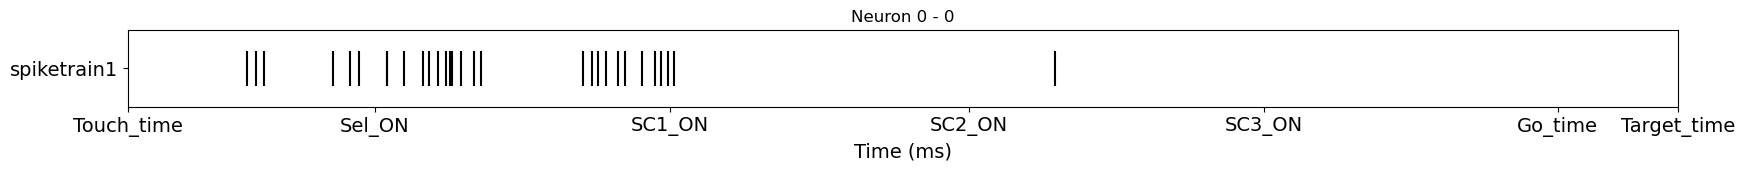

In [31]:
import matplotlib.pyplot as plt 

neuron = 0
trial = 0 

spiketrain1 = spike_train_trial[neuron][trial]

plt.figure(figsize=(20, 1))
plt.eventplot(spiketrain1.magnitude, linelengths=0.75, color='black')
plt.xticks(trials_ts[neuron][1][trial], event_labels,fontsize=14)

plt.xlabel('Time (ms)', fontsize=14)
plt.yticks([1], labels=["spiketrain1"], fontsize=14)
plt.title(f"Neuron {neuron} - {trial}");
print(mean_fr[neuron][trial])

trial = 1 
spiketrain2 = spike_train_trial[neuron][trial]

plt.figure(figsize=(20, 1))
plt.eventplot(spiketrain2.magnitude, linelengths=0.75, color='black')
plt.xticks(trials_ts[neuron][1][trial], event_labels,fontsize=14)
plt.xlabel('Time (ms)', fontsize=14)
plt.yticks([1], labels=["spiketrain2"], fontsize=14)
plt.title(f"Neuron {neuron} - {trial}");
print(mean_fr[neuron][trial])


### SPIKE : mean fr by trial

In [37]:
from neo.core import SpikeTrain
from elephant.statistics import mean_firing_rate


def mean_fr_by_trial(trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    mean_fr_by_ = []
    spike_train = []

    
    n_neurons = len(spike_times)

    for unit_idx in range(n_neurons):
        mean_fr_by_.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*s, t_start=t_start, t_stop=t_stop)
            spike_train[unit_idx].append(spk_ts_trial)

            mean_fr_by_[unit_idx].append(mean_firing_rate(spk_ts_trial)*1000)

    return spike_train, mean_fr_by_


In [38]:
spike_train_trial, mean_fr_by_trial = mean_fr_by_trial(trials_ts, spike_times)

In [32]:
spike_train_trial[0][0]

SpikeTrain containing 7 spikes; units s; datatype float64 
time: 2330253.0 s to 2337168.0 s

In [36]:
spike_train_trial[32][1]

SpikeTrain containing 53 spikes; units s; datatype float64 
time: 105639.0 s to 112550.0 s

In [39]:
spiketrain1 = spike_train_trial[32][1]

In [40]:
from elephant.statistics import time_histogram, instantaneous_rate
histogram_count = time_histogram(spiketrain1, 100*ms)
histogram_rate = time_histogram([spiketrain1], 100*ms, output='rate')


In [41]:
plt.figure(dpi=150)

# plotting the original spiketrain
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=25, markeredgewidth=2, lw=0, label='spike train')

# mean firing rate
plt.hlines(mean_firing_rate(spiketrain1), xmin=spiketrain1.t_start, xmax=spiketrain1.t_stop, linestyle='--', label='mean firing rate')

# time histogram
plt.bar(histogram_rate.times, histogram_rate.magnitude.flatten(), width=histogram_rate.sampling_period, align='edge', alpha=0.3, label='time histogram (rate)')


# axis labels and legend
plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))
plt.xlim(spiketrain1.t_start, spiketrain1.t_stop)
plt.legend()
plt.show()

KeyboardInterrupt: 

### Compute measures

In [25]:
total_trial_task = trials_ts[neurone_complet][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[neurone_complet][1], columns=event_labels, index=np.arange(0, total_trial_task))

In [36]:
df_task_ts

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,36636,37729,39037,40359,41667,42966,43499
1,46409,47487,48796,50104,51412,52697,53284
2,57059,58116,59435,60743,62065,63364,63991
3,77474,78592,79913,81252,82570,83868,84342
4,104813,105891,107200,108522,109830,111115,111769
...,...,...,...,...,...,...,...
101,1333755,1334865,1336173,1337482,1338790,1340078,1340591
102,1343679,1344757,1346065,1347390,1348709,1349993,1350635
103,1357443,1358534,1359856,1361164,1362485,1363770,1364317
104,1373928,1374994,1376302,1377610,1378932,1380218,1380790


###  SPIKE : mean fr by period

In [ ]:
from neo.core import SpikeTrain
from elephant.statistics import mean_firing_rate


def mean_fr(trials_ts, spike_times, event_labels): 
     
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_rate = []    
    n_neurons = len(spike_times)

    for unit_idx in range(n_neurons):
        spk_rate.append([])
        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            spk_rate[unit_idx].append([])

            for event in range(len(event_labels) - 1):
                # define the start and end time of each trial
                t_start = trials_ts[unit_idx][1][trial,event]
                t_stop = trials_ts[unit_idx][1][trial, event+1]
                
                # get spikes between start and end of trial 
                spk_tmp = spike_times[unit_idx][1] 
                sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
                
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop)
                mean = mean_firing_rate(spk_ts_trial)*1000 
               
                spk_rate[unit_idx][trial].append(mean.magnitude)

    return  spk_rate 

In [ ]:
spk_rate  = mean_fr(trials_ts, spike_times, event_labels)

In [ ]:
len(spk_rate[0])

49

## Last step : df par periodes pour tous les neurones by trials 

In [45]:
n_units = len(spike_times)


for unit in range(4):
    filename = spike_times[unit][0][1]
    print(filename)
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', filename)
    match_contact = re.search(r'contact(\d+)', filename)
    match_unit = re.search(r'unit(\d+)', filename)

    probe_idx = int(match_probe.group(1))
    contact_idx = int(match_contact.group(1))
    unit_idx = int(match_unit.group(1))

    sub_data = info_session[(info_session['probe'] == probe_idx) & (info_session['channel'] == contact_idx) & (info_session['unit'] == unit_idx)]

    print(sub_data[['probe', 'channel' , 'unit']])
    print('\n')

    idx_min_trial = df_task_ts_by_neuron[unit][1].index[0]
    idx_max_trial = df_task_ts_by_neuron[unit][1].index[-1]
    idx_trials = np.arange(idx_min_trial, idx_max_trial + 1) 

    elitrials = sub_data['elitrials'].values[0]

    if elitrials is not None : 
        print(elitrials)
        # Initialize an empty array to store the result
        list_elitrials = np.array([])

        for trial_range in range(len(elitrials)):
            start = elitrials[trial_range][0]
            stop = elitrials[trial_range][-1]           
            
            # Create a range of values and concatenate it to the result
            list_elitrials = np.concatenate((list_elitrials, np.arange(start, stop + 1)))

        print(list_elitrials)

        # create the index list 
        print(idx_trials)
        print(f'{idx_trials.shape} - {len(list_elitrials)}') 

        # exclude elitrials 
        idx_trials = idx_trials[~np.isin(idx_trials, list_elitrials)]
        print(idx_trials)



t150204001_probe1_contact6_unit1.mat
     probe  channel  unit
162      1        6     1


[[123, 128]]
[123. 124. 125. 126. 127. 128.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
(49,) - 6
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
t150204001_probe2_contact24_unit1.mat
     probe  channel  unit
208      2       24     1


[[129, 139]]
[129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]
(54,) - 11
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]
t150204001_probe1_contact19_unit1.mat
     prob

In [228]:
load_info[0]

(0, 't150204001_probe1_contact6_unit1.mat')

In [111]:
elitrials = sub_data['elitrials'].values[0]

In [112]:
elitrials

[[140, 144]]

In [69]:
trials_ts[3][1].shape

(54, 7)

In [115]:
# same bloc / without elitrials 
id_1 = 3
id_2 = 4
id_3 = 9
# same bloc / with elitrials 
id_4 = 34

# bloc 4 / 8 - elitrials [55,69] [129,139]
id_5 = 12

# bloc 9/11 - elitrials [[140, 144]]
id_6 = 22

In [116]:
print(spike_times[id_1][0], df_task_ts_by_neuron[id_1][1].shape)
print(spike_times[id_2][0], df_task_ts_by_neuron[id_2][1].shape)
print(spike_times[id_3][0], df_task_ts_by_neuron[id_3][1].shape)
print(spike_times[id_4][0], df_task_ts_by_neuron[id_4][1].shape)
print(spike_times[id_5][0], df_task_ts_by_neuron[id_5][1].shape)
print(spike_times[id_6][0], df_task_ts_by_neuron[id_6][1].shape)

(3, 't150204001_probe1_contact17_unit1.mat') (54, 7)
(4, 't150204001_probe1_contact12_unit1.mat') (54, 7)
(9, 't150204001_probe2_contact23_unit1.mat') (54, 7)
(34, 't150204001_probe2_contact11_unit1.mat') (49, 7)
(12, 't150204001_probe2_contact21_unit1.mat') (59, 7)
(22, 't150204001_probe1_contact1_unit2.mat') (33, 7)


In [117]:
df_task_ts_by_neuron[id_6][1].head()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,2832226,2833327,2834636,2835944,2837265,2838550,2839325
1,2928941,2930018,2931326,2932635,2933943,2935228,2935709
2,2939596,2940698,2942006,2943328,2944649,2945948,2946348
3,2949579,2950687,2952005,2953326,2954635,2955947,2956453
4,2959288,2960388,2961697,2963005,2964326,2965612,2966266


In [118]:
df_task_ts_by_neuron[id_6][1].tail(6)

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
27,3417948,3419039,3420347,3421655,3422964,3424248,3424836
28,3427744,3428813,3430132,3431440,3432749,3434034,3434577
29,3488819,3489885,3491206,3492515,3493823,3495121,3495791
30,3498993,3500111,3501419,3502727,3504049,3505334,3506030
31,3518800,3519868,3521190,3522498,3523823,3525133,3525652
32,3534627,3535700,3537009,3538317,3539639,3540937,3541739


In [120]:
t_start = 2832226

df_task_ts[df_task_ts['Touch_time'] == t_start]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
138,2832226,2833327,2834636,2835944,2837265,2838550,2839325


In [121]:
t_stop = 3541739

df_task_ts[df_task_ts['Target_time'] == t_stop]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


In [222]:
df_task_ts.loc[138:175]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
138,2832226,2833327,2834636,2835944,2837265,2838550,2839325
139,2858840,2859920,2861241,2862563,2863884,2865169,2865777
140,2869364,2870439,2871747,2873069,2874377,2875662,2876237
141,2890057,2891158,2892466,2893774,2895096,2896380,2896915
142,2899852,2900929,2902251,2903559,2904867,2906166,2906660
143,2910892,2911970,2913291,2914626,2915934,2917219,2917807
144,2928941,2930018,2931326,2932635,2933943,2935228,2935709
145,2939596,2940698,2942006,2943328,2944649,2945948,2946348
146,2949579,2950687,2952005,2953326,2954635,2955947,2956453
147,2959288,2960388,2961697,2963005,2964326,2965612,2966266


In [410]:
idx_min_trial = df_task_ts_by_neuron[38][1].index[0]
idx_max_trial = df_task_ts_by_neuron[38][1].index[-1]
idx_trials = np.arange(idx_min_trial, idx_max_trial + 1) 

In [425]:
t_start = df_task_ts_by_neuron[38][1].loc[idx_min_trial]['Touch_time']
t_stop = df_task_ts_by_neuron[38][1].loc[idx_max_trial]['Target_time']
df_task_ts[df_task_ts['Touch_time'] == t_start]
df_task_ts[df_task_ts['Target_time'] == t_stop]

1903682


In [424]:
df_task_ts[df_task_ts['Touch_time'] == t_start]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
91,1903682,1904816,1906134,1907442,1908751,1910049,1910596


In [428]:
df_task_ts[df_task_ts['Target_time'] == t_stop]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
155,3047992,3049069,3050391,3051713,3053021,3054320,3054799


In [454]:
df_task_ts_by_neuron[38][1]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,1903682,1904816,1906134,1907442,1908751,1910049,1910596
1,1923826,1924904,1926212,1927534,1928855,1930140,1930660
2,1934265,1935360,1936678,1937986,1939294,1940579,1941220
3,1943984,1945061,1946372,1947691,1949013,1950297,1950779
4,1970209,1971320,1972628,1973936,1975245,1976530,1977036
...,...,...,...,...,...,...,...
60,3008437,3009584,3010903,3012225,3013536,3014849,3015406
61,3018262,3019353,3020675,3021983,3023305,3024590,3025123
62,3028354,3029432,3030754,3032075,3033384,3034671,3035190
63,3038176,3039271,3040579,3041887,3043196,3044481,3045028


In [456]:
df_task_ts.loc[91:155]

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
91,1903682,1904816,1906134,1907442,1908751,1910049,1910596
92,1923826,1924904,1926212,1927534,1928855,1930140,1930660
93,1934265,1935360,1936678,1937986,1939294,1940579,1941220
94,1943984,1945061,1946372,1947691,1949013,1950297,1950779
95,1970209,1971320,1972628,1973936,1975245,1976530,1977036
...,...,...,...,...,...,...,...
151,3008437,3009584,3010903,3012225,3013536,3014849,3015406
152,3018262,3019353,3020675,3021983,3023305,3024590,3025123
153,3028354,3029432,3030754,3032075,3033384,3034671,3035190
154,3038176,3039271,3040579,3041887,3043196,3044481,3045028


In [469]:
df_task_ts.loc[91+69]

Touch_time     3122722
Sel_ON         3123801
SC1_ON         3125122
SC2_ON         3126430
SC3_ON         3127738
Go_time        3129036
Target_time    3129636
Name: 160, dtype: int64

In [470]:
spk_trials[36][69]

array([2363844, 2363865, 2363881, 2363914, 2364006, 2364023, 2364063,
       2364121, 2364186, 2364213, 2364256, 2364278, 2364334, 2364412,
       2364464, 2364498, 2364526, 2364598, 2364693, 2364822, 2365013,
       2365089, 2365140, 2365215, 2365271, 2365291, 2365338, 2365527,
       2365541, 2365638, 2365949, 2366079, 2366124, 2366473, 2366565,
       2366611, 2366667, 2366705, 2366893, 2366951, 2367007, 2367261,
       2367306, 2367490, 2367669, 2367703, 2367735, 2368194, 2368277,
       2368379, 2368499, 2368510, 2368591, 2368810, 2368913, 2368939,
       2368966, 2369003, 2369061, 2369277, 2369408, 2369760, 2369918,
       2370024, 2370254, 2370266, 2370328, 2370430, 2370457, 2370528,
       2370537, 2370694], dtype=int32)

In [218]:
df_task_ts

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,61233,62310,63629,64937,66258,67543,68156
1,105639,106751,108096,109404,110712,111997,112550
2,179281,180344,181696,183014,184322,185620,186341
3,216446,217522,218831,220139,221460,222763,223389
4,226804,227881,229203,230511,231836,233148,233869
...,...,...,...,...,...,...,...
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652


In [214]:
# same bloc / without elitrials 
id_1 = 3
id_2 = 4
id_3 = 9
# same bloc / with elitrials 
id_4 = 34

# bloc 4 / 8 - elitrials [55,69] [129,139]
id_5 = 12

# bloc 9/11 - elitrials [[140, 144]]
id_6 = 22

units_list = [id_1, id_2, id_3, id_4, id_5, id_6]

In [215]:
units_list

[3, 4, 9, 34, 12, 22]

# SPIKE RATE + TARGET 

In [26]:
# get target by trial and neuron
n_units = len(target_info)

list_trial_type = []
list_position = []
list_type_and_pos = []

for unit in range(n_units):
    #print(f'neuron {unit}')
    list_trial_type.append([])
    list_position.append([])
    list_type_and_pos.append([])
    trial_type = target_info[unit][1]['Trial_type']
    n_trials = trial_type.shape[0]

    for trial in range(n_trials):
        #print(f'trial type : {trial_type[trial]}')
        valid_cue_idx = target_info[unit][1]['Trial_type'][trial] - 1
        valid_cue = list(target_info[unit][1].keys())[valid_cue_idx]
        position = target_info[unit][1][f'{valid_cue}'][trial]
        #print(f'position : {position}')
        list_trial_type[unit] = list(trial_type)
        list_position[unit].append(position)

    cue_position = list(zip(list_trial_type[unit], list_position[unit]))
    cue_pos_combinations = sorted(set(cue_position))

    # build the target accoring the combination of the cue/direction
    cue_and_pos = []
    for sel_cue, direction in cue_position:
        cue_and_pos.append(cue_pos_combinations.index((sel_cue, direction)))

    list_type_and_pos[unit] = cue_and_pos

In [27]:
from neo.core import SpikeTrain
from elephant.statistics import mean_firing_rate

n_units = len(spike_times)
n_event = event_labels[:-1]

cols = []
for i in range(n_units): 
    cols.append(f'neuron{i}')   

cols.insert(0, 'period')
cols.insert(1, 'trial_type')
cols.insert(2, 'position')
cols.insert(3, 'type_and_pos')



list_df_spk = []
list_spike_train = []
list_idx_trial = []

for i, event in enumerate(event_labels[:-1]):
    df = pd.DataFrame(columns=cols, index=df_task_ts.index)
    df['period'] = event
    #print(event)
    list_spike_train.append([])

    for unit in range(n_units) :
        #print(f'NEURON : {unit}')
        #print(spike_times[unit][0])
        times_unit = df_task_ts_by_neuron[unit][1]
        n_trials = times_unit.shape[0]
        list_spike_train[i].append([])
        list_idx_trial.append([])


        for trial in range(n_trials):            #print(f'trial :{trial}')
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            #print(t_start, t_stop)

            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)

            spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop)
            list_spike_train[i][unit].append(spk_ts_trial)

            mean_fr = mean_firing_rate(spk_ts_trial)*1000 

            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

            if i == 0 : 
                list_idx_trial[unit].append(idx_trial)

            #print(spk_tmp[sel_spk])
            #print(mean_fr.magnitude)

            df.loc[idx_trial, f'neuron{unit}'] = mean_fr.magnitude
            df.loc[idx_trial, 'trial_type'] = list_trial_type[unit][trial]
            df.loc[idx_trial, 'position'] = list_position[unit][trial]
            df.loc[idx_trial, 'type_and_pos'] = list_position[unit][trial]

    list_df_spk.append(df)
    

In [28]:
target = {\
    'trial_type' : list_df_spk[0]['trial_type'].values, 
    'position' : list_df_spk[0]['position'].values, 
    'type_and_pos': list_df_spk[0]['type_and_pos'].values}

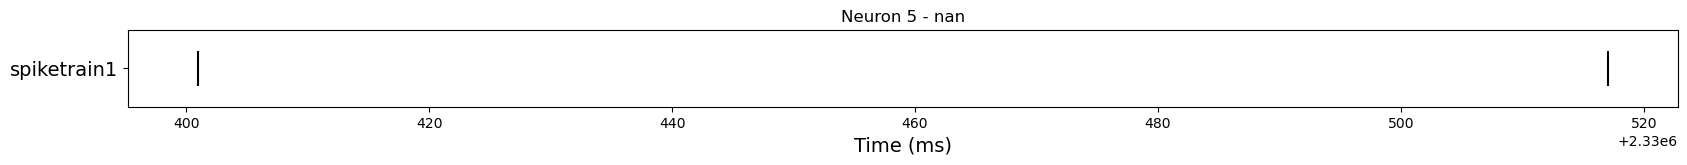

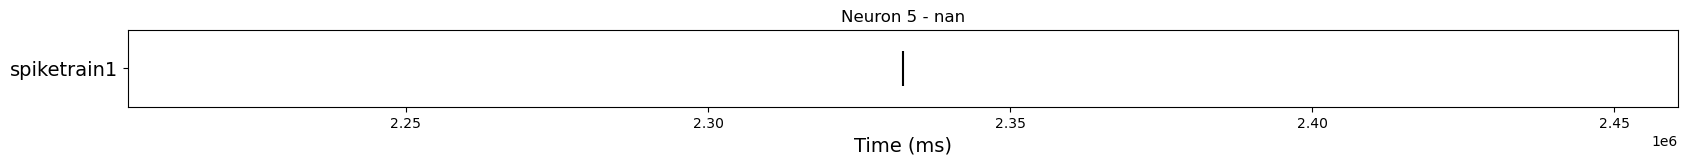

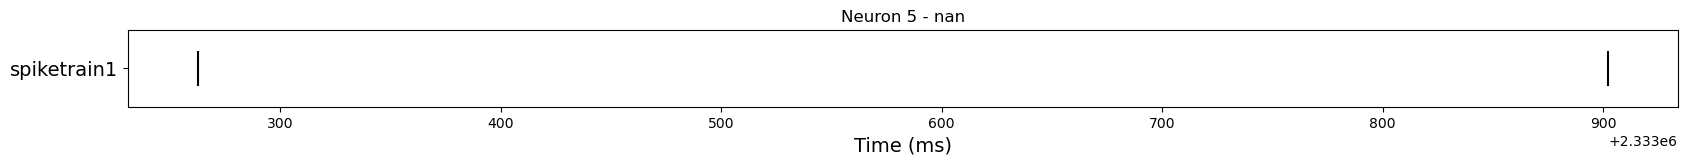

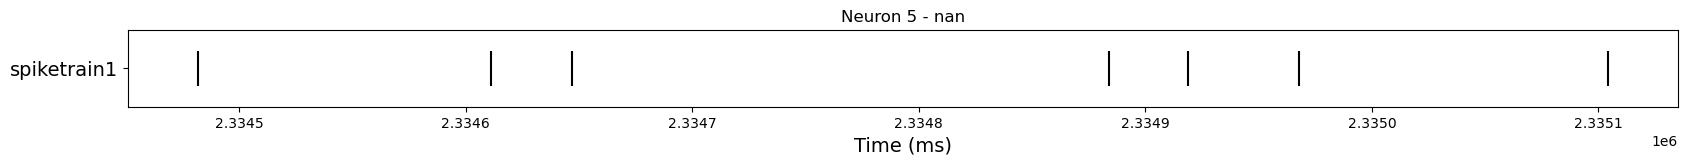

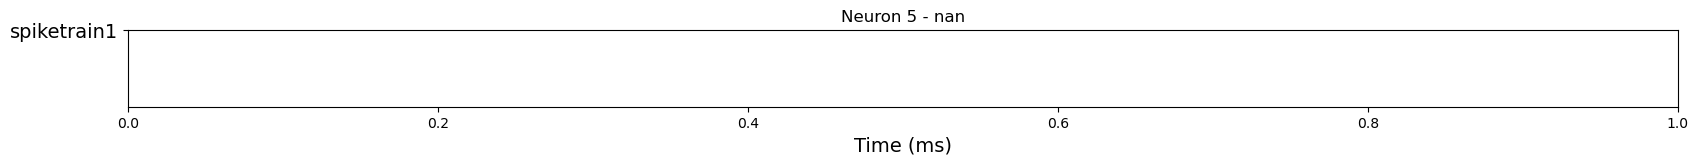

In [29]:
import matplotlib.pyplot as plt 

trial = 0
neuron = 5

for i in range(0,5): 
    spiketrain = list_spike_train[i][neuron][trial]
    #x_axis = np.arange(df_task_ts_by_neuron[neuron][1].loc[trial][i], df_task_ts_by_neuron[neuron][1].loc[trial][i+1])

    plt.figure(figsize=(20, 1))
    plt.eventplot(spiketrain.magnitude, linelengths=0.75, color='black')
    #plt.xticks(np.arange(spiketrain.t_start, spiketrain.t_stop))

    plt.xlabel('Time (ms)', fontsize=14)
    plt.yticks([1], labels=["spiketrain1"], fontsize=14)
    plt.title(f"Neuron {neuron} - {list_df_spk[i].loc[trial][f'neuron{neuron}']}");

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


In [31]:
# Build pipeline
n_splits = 50
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
scaler = StandardScaler()
estimator = LogisticRegression(C = 0.5, random_state=0, max_iter = 500)
clf = make_pipeline(scaler, estimator)

In [32]:
def struct_dataset(df_feature, target, measure):
    
    if measure == 'sync':
        cols_to_drop = list(df_feature.columns[0:5])
    else:
        cols_to_drop = list(df_feature.columns[0:4])

    data = df_feature.drop(columns=cols_to_drop)
    target = pd.DataFrame(target, dtype='uint8')


    return data, target

In [33]:
class Model_info:

    def __init__(self, n_splits, n_events, data, target, cvs, clf):
        self.n_splits = n_splits
        self.n_periods = n_events
        self.data = data
        self.target = target
        self.cvs = cvs
        self.clf = clf

In [34]:
n_events = len(event_labels) - 1

list_data_sync = []
list_target_sync = []
list_sync_model = []
list_data_rate = []
list_target_rate = []
list_rate_model = []


In [35]:
for event in range(n_events):
    
    list_data_sync.append([])
    list_target_sync.append([])
    list_sync_model.append([])

    list_df_spk[event] = list_df_spk[event].fillna(0)

    data_rate, target_rate = struct_dataset(\
        list_df_spk[event], target, measure ='rate')

    model_rate = Model_info(n_splits,\
             n_events, data_rate, target_rate, cvs0, clf)

    list_data_rate.append(data_rate)
    list_target_rate.append(target_rate)
    list_rate_model.append(model_rate)

In [36]:
periods_names = list(task_info.keys())

In [37]:
def classif_rate(list_model, periods_names):

    #acc = np.zeros(list_model[0][0].n_splits)
    #acc_shuf = np.zeros(list_model[0][0].n_splits)
    acc_df = pd.DataFrame(\
        columns=['split', 'data_type', 'period', 'target_type', 'accuracy', 'y_true', 'y_pred'])

 
    model_ = list_model[0]
    data_ = list_model[0].data
    target_ = list_model[0].target
    n_periods = list_model[0].n_periods
    n_targets = list_model[0].target.shape[1]


    for i_split, (train_ind, test_ind) in enumerate(model_.cvs.split(data_,target_)):

        print('#################')
        print('SPLIT :', i_split)
        print('##################')
        
        for per_idx in range(n_periods):
    
    
            model = list_model[per_idx]
            data = model.data

            for idx_target in range(n_targets):
                

                target_ =  model.target.iloc[:,idx_target]
                target_name = model.target.columns[idx_target]

                #print(periods_names[per_idx], sigma[sig_indx], target_name)

                # train classifier 
                model.clf.fit(data.loc[train_ind,:], target_.loc[train_ind])
            
                # test classifier 
                y_pred =  model.clf.predict(data.loc[test_ind,:])
                y_true = target_.loc[test_ind].values
                
                acc = accuracy_score(y_true, y_pred)
                
                
                # save test perfomance
                d = {
                    'split' : [i_split],
                    'data_type': ['test'],
                    'period': [f'{periods_names[per_idx]}'],
                    'target_type' : target_name, 
                    'accuracy': [acc],
                    'y_true' : [y_true],
                    'y_pred': [y_pred]
                    }

                acc_df = pd.concat((acc_df, pd.DataFrame(data=d)), ignore_index=True)
            
                #  train classfier on shuffled data
                ind_train_shuf = np.random.permutation(train_ind)
                model.clf.fit(data.loc[train_ind,:],  target_.loc[ind_train_shuf])
            
                # test classfier on shuffled data
                y_pred_shuf =  model.clf.predict(data.loc[test_ind,:])
                acc_shuf = accuracy_score(y_true, y_pred_shuf)
                
                # save shuffled perfomance
                d_shuff = {
                    'split' : [i_split],
                    'data_type': ['shuff'],
                    'period': [f'{periods_names[per_idx]}'],
                    'target_type' : target_name, 
                    'accuracy': [acc_shuf],
                    'y_true' : [y_true],
                    'y_pred': [y_pred_shuf]
                    }
            
                acc_df = pd.concat((acc_df, pd.DataFrame(data=d_shuff)), ignore_index=True)

    return acc_df


In [38]:
acc_df = classif_rate(list_rate_model, periods_names)
acc_df.to_csv('acc_df_merged_{session}.csv')

#################
SPLIT : 0
##################
#################
SPLIT : 1
##################
#################
SPLIT : 2
##################
#################
SPLIT : 3
##################
#################
SPLIT : 4
##################
#################
SPLIT : 5
##################
#################
SPLIT : 6
##################
#################
SPLIT : 7
##################
#################
SPLIT : 8
##################
#################
SPLIT : 9
##################
#################
SPLIT : 10
##################
#################
SPLIT : 11
##################
#################
SPLIT : 12
##################
#################
SPLIT : 13
##################
#################
SPLIT : 14
##################
#################
SPLIT : 15
##################
#################
SPLIT : 16
##################
#################
SPLIT : 17
##################
#################
SPLIT : 18
##################
#################
SPLIT : 19
##################
#################
SPLIT : 20
##################
##

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


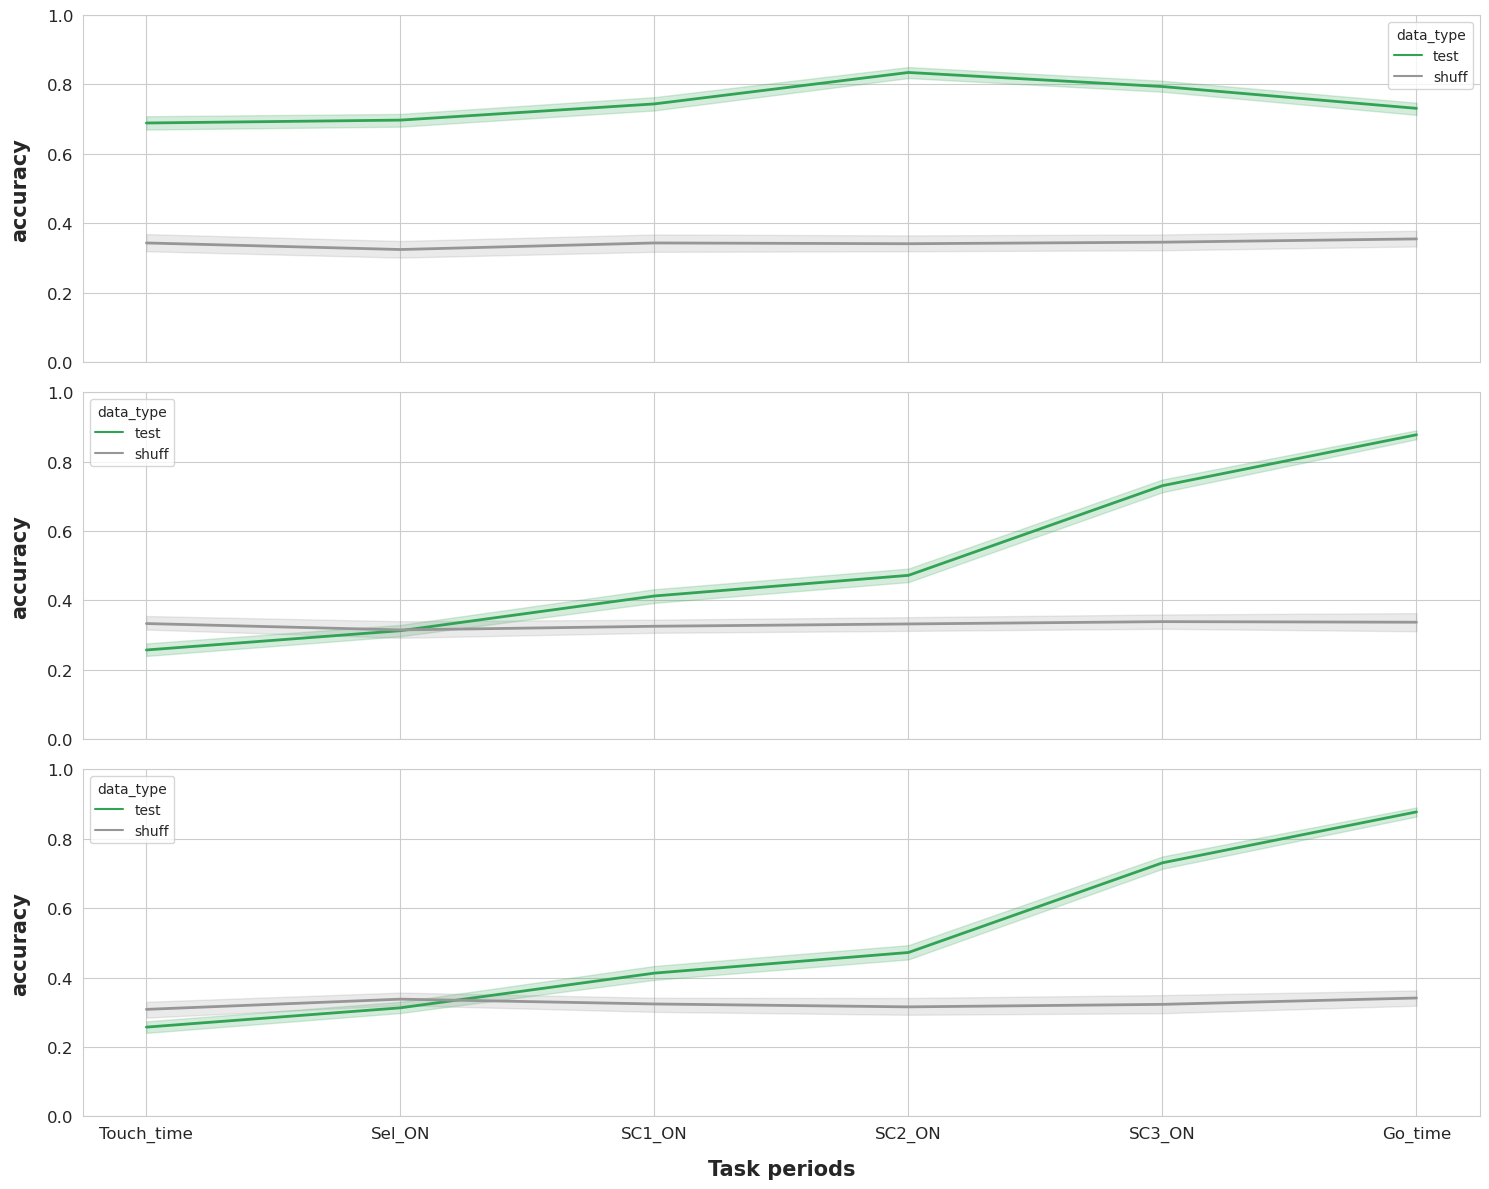

In [40]:
spk_accuracy = acc_df
target_list = ['trial_type', 'position', 'type_and_pos']

palette_spk = ['#31a354', '#969696']


plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12 

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey= True, dpi=100)  

#axs[0,0].set_ylabel('Type\n', fontsize=14, weight='bold')
#axs[1,0].set_ylabel('Position\n', fontsize=14, weight='bold')
#axs[2,0].set_ylabel('Type and position\n', fontsize=14, weight='bold')
legend_labels = []
legend_handles = []


for i, target in enumerate(target_list):

    accuracy_plot = spk_accuracy.rename(columns={"period": "Task periods", "score" : "accuracy"}, inplace=False)#\
    #.replace(to_replace = periods_names[:-2], value=['Touch', 'Selection Cue', 'Spatial Cue 1', 'Spatial Cue 2', 'Spatial Cue 3', 'Go'], inplace=False)\
    #.replace(to_replace=['test', 'shuff'], value=['test', 'shuffled'], inplace=False)
    
    accuracy_plot = accuracy_plot[accuracy_plot["target_type"] == target]

    sns.lineplot(accuracy_plot, x='Task periods', y='accuracy', hue='data_type', palette=palette_spk, linewidth = 2., ax=axs[i])

    #axs[0,0].set_title('Firing-rate decoding', fontsize= 16, weight='bold')
    axs[i].set_yticks(np.arange(0,1.1,0.2))
    

plt.tight_layout()

#time = datetime.now().strftime('%d_%m_%H_%M_%S')
#plt.savefig(f'./results/figures_results/accuracy_{time}.png'


# SYNCH

In [41]:
def align_time(df_task_ts):
    times_aligned = np.array(df_task_ts)

    for trial in range(len(times_aligned)):
        times_aligned[trial] -= times_aligned[trial][0]
         

    times_aligned = np.array(times_aligned, dtype=object)

    return times_aligned

times_aligned = align_time(df_task_ts)

In [42]:
from neo.core import SpikeTrain
from elephant.statistics import mean_firing_rate


def align_spike(trials_ts, spike_times, event_labels): 
     
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    n_neurons = len(spike_times)

    spikes_aligned = []    
    spikes_binarized = []

    for unit_idx in range(n_neurons):
        spikes_aligned.append([])
        spikes_binarized.append([])

        spk_tmp = spike_times[unit_idx][1] 
        n_trials = trials_ts[unit_idx][1].shape[0]  

        for trial in range(n_trials):
            spikes_aligned[unit_idx].append([])
            spikes_binarized[unit_idx].append([])

            for event in range(len(event_labels) - 1):
                # define the start and end time of each trial
                t_start = trials_ts[unit_idx][1][trial,event]
                t_stop = trials_ts[unit_idx][1][trial, event+1]
                # get spikes between start and end of trial and align to zero
                sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
                spikes_aligned[unit_idx][trial].append(spk_tmp[sel_spk] - t_start)
                
                # get continuous spike trains
                n_times = (t_stop - t_start)
                spikes_binarized[unit_idx][trial].append(np.linspace(0, 0, num=n_times+1,  dtype=float))

                for spk in spk_tmp[sel_spk]:
                    spk_aligned = spk - t_start
                    spikes_binarized[unit_idx][trial][event][spk_aligned] = 1

    return  spikes_aligned, spikes_binarized

In [43]:
spikes_aligned, spikes_binarized = align_spike(trials_ts, spike_times, event_labels)

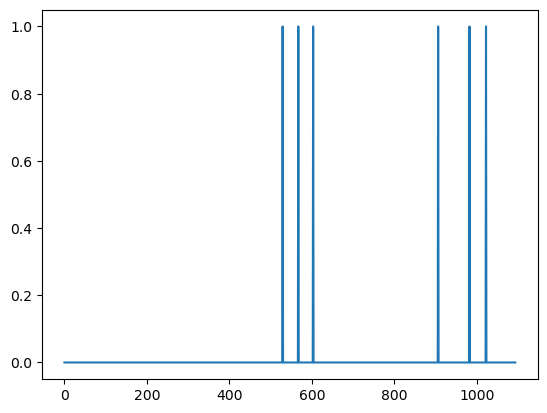

In [44]:
plt.plot(spikes_binarized[0][0][0])

In [337]:
sigma = [50]
delta_time = 1
sigma_dt = sigma * delta_time 

sigma_dt

[50]

In [63]:
list_idx_trial[20]

[8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75]

In [64]:
list_idx_trial = list_idx_trial[:21]

In [65]:
len(list_idx_trial)

21

In [91]:
df_task_ts.loc[0]['Touch_time']

36636

In [89]:
list(df_task_ts.columns)[:-1]

['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time']

In [112]:
import scipy.ndimage as spn 

n_units = len(spikes_aligned)
n_trials = df_task_ts.shape[0]
events = list(df_task_ts.columns)
n_events = len(events) - 1

spike_convolved = []


for unit in range(n_units):
    spike_convolved.append([])
    for trial in range(n_trials):
        spike_convolved[unit].append([])
        for i in range(n_events): 
            spike_convolved[unit][trial].append([])

            # define the start and end time of each trial
            t_start = df_task_ts.loc[trial][f'{events[i]}']
            t_stop =  df_task_ts.loc[trial][f'{events[i+1]}']
            n_times = (t_stop - t_start)
            
            spike_convolved[unit][trial][i].append(np.linspace(0, 0, num=n_times+1,  dtype=float))

In [115]:
spike_convolved[0][0][0]

[array([0., 0., 0., ..., 0., 0., 0.])]

In [124]:
len(spikes_binarized[1][0])

6

In [140]:

sigma = [50]
delta_time = 1
sigma_dt = sigma * delta_time 

for unit in range(n_units):
    #print('unit')
    #print(unit)
    for t, trial_unit in enumerate(list_idx_trial[unit]):
        #print(trial)
        for i in range(n_events):
            #print('period id')
            #print(i)  
            for s in range(len(sigma)):
                scaling = sigma_dt[s] * np.sqrt(2*np.pi)
                smoothed_spk = spn.gaussian_filter1d(spikes_binarized[unit][t][i], sigma_dt[s]) * scaling
                spike_convolved[unit][t][i] = smoothed_spk

spk_convol = np.array(spike_convolved, dtype=object)

spk_sync = np.zeros((n_trials, n_events, len(sigma), n_units, n_units))

# correlation between neurons 
for trial in range(n_trials):
    for per in range(n_events):
        for s in range(len(sigma)) :
            for neurone1 in range(n_units):
                for neurone2 in range(n_units):
                    spk_sync[trial][per][s][neurone1][neurone2] = np.sum(
                        spk_convol[neurone1][trial][per]*spk_convol[neurone2][trial][per])

ValueError: operands could not be broadcast together with shapes (1094,) (1079,) 

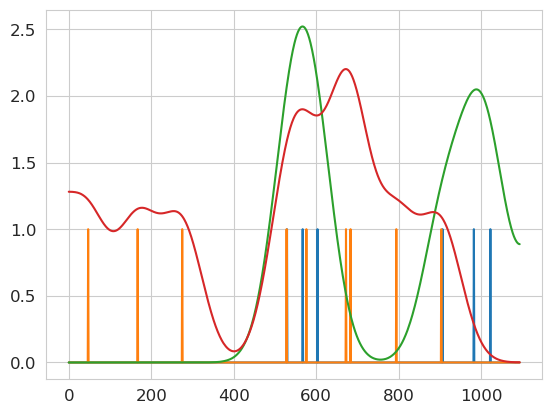

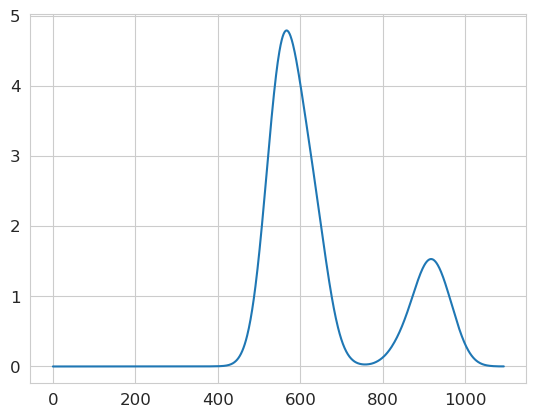

In [141]:
plt.figure()
plt.plot(spikes_binarized[0][0][0])
plt.plot(spikes_binarized[2][0][0])

plt.plot(spk_convol[0][0][0])
plt.plot(spk_convol[2][0][0])

plt.figure()
plt.plot(spk_convol[0][0][0]*spk_convol[2][0][0])

In [ ]:
def synchrony(Info_session, sigma, spk_convol):
    
    n_neurons = Info_session.n_neurons
    n_trials = Info_session.n_trials
    n_periods = Info_session.n_periods

    spk_sync = np.zeros((n_trials, n_periods-1, len(sigma), n_neurons, n_neurons))


    # correlation between neurons 
    for trial in range(n_trials):
        for per in range(n_periods - 1):
            for s in range(len(sigma)) :
                for neurone1 in range(n_neurons):
                    for neurone2 in range(n_neurons):
                        spk_sync[trial][per][s][neurone1][neurone2] = np.sum(
                            spk_convol[neurone1][trial][per][s]*spk_convol[neurone2][trial][per][s])
    
    return  spk_sync

spk_sync = compute_measures.synchrony(Info_session, sigma, spk_convol)

# Draft ?

In [ ]:
df_spk = pd.DataFrame(columns = df_task_ts.columns, index=df_task_ts.index)

n_units = len(spike_times)


for unit in range(4):
    filename = spike_times[unit][0][1]
    print(filename)
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', filename)
    match_contact = re.search(r'contact(\d+)', filename)
    match_unit = re.search(r'unit(\d+)', filename)

    probe_idx = int(match_probe.group(1))
    contact_idx = int(match_contact.group(1))
    unit_idx = int(match_unit.group(1))

    sub_data = info_session[(info_session['probe'] == probe_idx) & (info_session['channel'] == contact_idx) & (info_session['unit'] == unit_idx)]

    print(sub_data[['probe', 'channel' , 'unit']])
    print('\n')

    idx_min_trial = df_task_ts_by_neuron[unit][1].index[0]
    idx_max_trial = df_task_ts_by_neuron[unit][1].index[-1]
    idx_trials = np.arange(idx_min_trial, idx_max_trial + 1) 

    elitrials = sub_data['elitrials'].values[0]

    if elitrials is not None : 
        print(elitrials)
        # Initialize an empty array to store the result
        list_elitrials = np.array([])

        for trial_range in range(len(elitrials)):
            start = elitrials[trial_range][0]
            stop = elitrials[trial_range][-1]           
            
            # Create a range of values and concatenate it to the result
            list_elitrials = np.concatenate((list_elitrials, np.arange(start, stop + 1)))

        print(list_elitrials)

        # create the index list 
        print(idx_trials)
        print(f'{idx_trials.shape} - {len(list_elitrials)}') 

        # exclude elitrials 
        idx_trials = idx_trials[~np.isin(idx_trials, list_elitrials)]
        print(idx_trials)



In [444]:
def mean_fr_all_neurons(df_task_ts, spike_times): 
     
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_rate = []    
    n_neurons = len(spike_times)
    n_trials = df_task_ts.shape[0]
    n_events = df_task_ts.shape[1]
    spk_rate_arr = np.zeros((n_neurons, n_trials, n_events-1))


    for unit_idx in range(2):
        spk_rate.append([])
        print(f'NEURON {unit_idx}')


        for trial in range(5):
            spk_rate[unit_idx].append([])
            print(f'TRIAL : {trial}\n')

            for event in range(len(event_labels) - 1):
                print(event_labels[event])
                # define the start and end time of each trial
                t_start = df_task_ts.loc[trial][event]
                t_stop = df_task_ts.loc[trial][event + 1]
                print(t_start, t_stop)
                
                # get spikes between start and end of trial 
                spk_tmp = spike_times[unit_idx][1] 
                sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
                print(spk_tmp[sel_spk])
                
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop)
                mean = mean_firing_rate(spk_ts_trial)*1000 

                print(mean.magnitude)
               
                spk_rate_arr[neuron][trial][event] = mean.magnitude 

    return  spk_rate_arr 

In [445]:
spk_rate = mean_fr_all_neurons(df_task_ts, spike_times)

NEURON 0
TRIAL : 0

Touch_time
61233 62310
[]
0.0
Sel_ON
62310 63629
[]
0.0
SC1_ON
63629 64937
[64137]
0.764525993883792
SC2_ON
64937 66258
[]
0.0
SC3_ON
66258 67543
[66628]
0.7782101167315175
Go_time
67543 68156
[]
0.0
TRIAL : 1

Touch_time
105639 106751
[]
0.0
Sel_ON
106751 108096
[]
0.0
SC1_ON
108096 109404
[108504 108968]
1.529051987767584
SC2_ON
109404 110712
[109958]
0.764525993883792
SC3_ON
110712 111997
[]
0.0
Go_time
111997 112550
[]
0.0
TRIAL : 2

Touch_time
179281 180344
[179944]
0.9407337723424272
Sel_ON
180344 181696
[180353 180395 180575]
2.2189349112426036
SC1_ON
181696 183014
[]
0.0
SC2_ON
183014 184322
[]
0.0
SC3_ON
184322 185620
[184670 184688 185496]
2.3112480739599386
Go_time
185620 186341
[186233]
1.3869625520110958
TRIAL : 3

Touch_time
216446 217522
[216590 217100 217134 217168 217400]
4.646840148698885
Sel_ON
217522 218831
[217524 218113]
1.5278838808250572
SC1_ON
218831 220139
[219105]
0.764525993883792
SC2_ON
220139 221460
[220620]
0.757002271006813
SC3_ON
221

In [448]:
def structure_spk_rate(spk_rate, event_labels):
    n_units = spk_rate.shape[0]
    n_events = spk_rate.shape[2]
    list_df_spk = []

    # structure firing rate in DataFrame
    for unit_idx in range(n_units):
        for event in range(n_events):

            df_spk = pd.DataFrame(spk_rate[:,:,event])
            df_spk = df_spk.T
            df_spk.insert(0, 'period', event_labels[event])

        list_df_spk.append(df_spk)

    return list_df_spk

In [449]:
list_df_spk = structure_spk_rate(spk_rate, event_labels)

In [450]:
list_df_spk[0]

,period,0,1,2,3,4,5,6,7,8,...,33,34,35,36,37,38,39,40,41,42
0,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Go_time,25.316456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def structure_spk_rate(Info_session, periods_names, spk_rate, target):
    n_periods = Info_session.n_periods
    list_df_spk = []

    # structure firing rate in DataFrame
    for per in range(n_periods - 1):

        df_spk = pd.DataFrame(spk_rate[:,:,per])
        df_spk = df_spk.T
        df_spk.insert(0, 'period', periods_names[per])

        idx_target = 0
        for target_name in target.keys(): 
            idx_target =+1
            df_spk.insert(idx_target, column= target_name, value=target[f'{target_name}'])
        
        list_df_spk.append(df_spk)

    return list_df_spk